### clear_output

In [8]:
from IPython.display import clear_output

clear_output()

### 画像のパスを全部取得する

In [ ]:
import os
from __future__ import division, print_function, unicode_literals

In [2]:
VOC_DATA_HOME = os.path.join(VOC_DOWNLOAD_PATH, 'VOCdevkit', 'VOC2012')

image_paths = list()
annotation_paths = list()

image_dir = os.path.join(VOC_DATA_HOME, 'JPEGImages')
for filepath in os.listdir(image_dir):
    if filepath.endswith('jpg'):
        image_paths.append(os.path.join(image_dir, filepath))
    
annotation_dir = os.path.join(VOC_DATA_HOME, 'Annotations')
for filepath in os.listdir(annotation_dir):
    if filepath.endswith('xml'):
        annotation_paths.append(os.path.join(annotation_dir, filepath))

In [3]:
image_paths.sort()
print(len(image_paths))
print(image_paths[0])
print(image_paths[301])

annotation_paths.sort()
print(len(annotation_paths))
print(annotation_paths[0])
print(annotation_paths[301])

17125
JPEGImages/2007_000027.jpg
JPEGImages/2007_004281.jpg
17125
Annotations/2007_000027.xml
Annotations/2007_004281.xml


### Annotationの.xmlファイルに整数ではないbounding box の値が存在するので、そのようなファイルを探す

In [9]:
from scipy.misc import imresize
from collections import defaultdict
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

In [18]:
def get_list_with_nonint_bndbox(annotation_paths):
    wrong_xml_paths = []
    for annotation_path in annotation_paths:
        tree = ET.parse(annotation_path)
        try:
            bnd_box_roots = tree.findall('object/bndbox')
            bnd_boxs = [(bnd_box_root.findtext('xmin'), bnd_box_root.findtext('ymin'),
            bnd_box_root.findtext('xmax'), bnd_box_root.findtext('ymax'),) 
            for bnd_box_root in list(bnd_box_roots)]
            
            for i in range(len(bnd_boxs)):
                a_ = int(bnd_boxs[i][0])
                b_ = int(bnd_boxs[i][1])
                c_ = int(bnd_boxs[i][2])
                d_ = int(bnd_boxs[i][3])
        except ValueError:
            wrong_xml_paths.append(annotation_path)
    return wrong_xml_paths

In [19]:
wrong_xml_paths = get_list_with_nonint_bndbox(annotation_paths = annotation_paths)

In [20]:
print(wrong_xml_paths)

['Annotations/2011_006777.xml']


### 画像からRegion proposal部分の画素とラベルと抽出し、InceptionV3の入力次元にresizeする関数の定義

In [4]:
def get_region_proposal_and_label(image_path, annotation_path, target_width = 299, target_height = 299):
    """return a dict of region_proposals 
         the key of which is the object label and 
         the value is a list of the img and the bounding box
         exp: {'person': [(fig1, bnd_box1), (fig2, bnd_box2)]}"""
    
    tree = ET.parse(annotation_path)
    object_names = [object_name.text for object_name in tree.findall('object/name')]
    bnd_box_roots = tree.findall('object/bndbox')
    bnd_boxs = [(bnd_box_root.findtext('xmin'), bnd_box_root.findtext('ymin'),
            bnd_box_root.findtext('xmax'), bnd_box_root.findtext('ymax'),) 
            for bnd_box_root in list(bnd_box_roots)]
    
    region_proposals = defaultdict(list)
    
    img = mpimg.imread(image_path)
    for i in range(len(bnd_boxs)):
        region_proposal = img[int(bnd_boxs[i][1]) : int(bnd_boxs[i][3]), int(bnd_boxs[i][0]) : int(bnd_boxs[i][2])]
        region_proposal = imresize(region_proposal, (target_width, target_height))
        region_proposal = region_proposal.astype(np.float32) / 255
        region_proposals[object_names[i]].append((region_proposal, bnd_boxs[i]))
    
    return region_proposals

In [5]:
region_proposals = get_region_proposal_and_label(image_path = os.path.join('JPEGImages', '2007_000027.jpg'),
                                                annotation_path = os.path.join('Annotations/2007_000027.xml'))
print(type(region_proposals[region_proposals.keys()[0]]))
print(region_proposals[region_proposals.keys()[0]][0][1])

<type 'list'>
('174', '101', '349', '351')


/anaconda3/envs/ai_course/lib/python2.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


### Region Proposal の画像データを新しいディレクトリーに保存し、画像のパスとラベルのリストを返す

In [6]:
voc_class_ids = {'person': 0, 'aeroplane': 1, 'bicycle': 2, 'bird': 3, 'boat': 4, 'bottle': 5, 'bus': 6, 'car': 7, 'cat': 8, 
                'chair': 9, 'cow': 10, 'diningtable': 11, 'dog': 12, 'horse': 13, 'motorbike': 14, 'pottedplant': 15, 
                'sheep': 16, 'sofa': 17, 'train': 18, 'tvmonitor': 19}

In [33]:
import datetime
try:
    import cPickle as pickle
except:
    import pickle as pickle

RP_IMAGES_PATH = os.path.join('rpimages')

def save_region_proposal_images(image_paths = image_paths, annotation_paths = annotation_paths):
    for image_path, annotation_path in zip(image_paths, annotation_paths):
        region_proposals = get_region_proposal_and_label(image_path = image_path, 
                                                         annotation_path = annotation_path)
        for label, imgs_with_bndbox in region_proposals.items():
            for img_with_bndbox in imgs_with_bndbox:
                now = datetime.datetime.now()
                filename = '{0:%H%M%f}'.format(now)
                np.save(os.path.join(RP_IMAGES_PATH, filename), img_with_bndbox[0])      #3/5ぐらいで39.8G消費した 
                #with open(os.path.join(RP_IMAGES_PATH, filename), 'wb') as f:      #毎回fileを開く動作が重い
                    #pickle.dump(img_with_bndbox[0].tolist(), f)
                #print(image_path)
                
                yield (os.path.join(RP_IMAGES_PATH, filename + '.npy'), voc_class_ids[label])

In [9]:
voc_paths_and_classes = []

if not os.path.exists(RP_IMAGES_PATH):
    os.makedirs(RP_IMAGES_PATH)
    
voc_save_counter = 0
    
for mid_yield in save_region_proposal_images():
    voc_paths_and_classes.append(mid_yield)
    voc_save_counter += 1
    if voc_save_counter >= 100:
        voc_save_counter = 0
        with open('voc_paths_and_classes', 'wb') as f:
            pickle.dump(voc_paths_and_classes, f)
            
with open('voc_paths_and_classes', 'wb') as f:
            pickle.dump(voc_paths_and_classes, f)

NameError: name 'RP_IMAGES_PATH' is not defined

40138
(u'rpimages/2226377960.npy', 0)


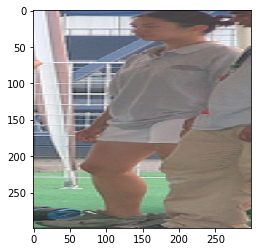

In [39]:
print(len(voc_paths_and_classes))
example = np.load(os.path.join(voc_paths_and_classes)[40000][0])
print(voc_paths_and_classes[40000])
plt.imshow(example)
plt.show()

### Inception v3モデルを読み込み、その出力層を変える

In [40]:
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [41]:
import tensorflow as tf
from tensorflow.contrib.slim.nets import inception
import tensorflow.contrib.slim as slim

reset_graph()

X = tf.placeholder(tf.float32, shape = [None, 299, 299, 3], name = 'X')
traning = tf.placeholder_with_default(False, shape = [])
with slim.arg_scope(inception.inception_v3_arg_scope()):
    logits, end_points = inception.inception_v3(X, num_classes = 1001, is_training = traning)

inception_saver = tf.train.Saver()

/anaconda3/envs/ai_course/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [42]:
end_points['PreLogits']

<tf.Tensor 'InceptionV3/Logits/Dropout_1b/cond/Merge:0' shape=(?, 1, 1, 2048) dtype=float32>

In [43]:
prelogits = tf.squeeze(end_points['PreLogits'], axis = [1, 2])

In [44]:
n_outputs = 20

with tf.name_scope('new_output_layer'):
    voc_logits = tf.layers.dense(prelogits, n_outputs, name = 'voc_logits')

In [45]:
learning_rate = 0.001

y = tf.placeholder(tf.int32, shape = [None])

with tf.name_scope('train'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits = voc_logits, labels = y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.MomentumOptimizer(learning_rate = learning_rate, momentum = 0.9, use_nesterov = True)
    voc_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope = 'voc_logits')
    training_op = optimizer.minimize(loss, var_list = voc_vars)
    
with tf.name_scope('eval'):
    correct = tf.nn.in_top_k(voc_logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
with tf.name_scope('init_and_save'):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [46]:
[v.name for v in voc_vars]

[u'voc_logits/kernel:0', u'voc_logits/bias:0']

### 学習データとテストデータの分割

In [58]:
from random import sample

def prepare_batch(voc_paths_and_classes, batch_size):
    batch_paths_and_classes = sample(voc_paths_and_classes, batch_size)
    images = [np.load(path) for path, labels in batch_paths_and_classes]
    X_batch = 2 * np.stack(images) - 1 #inception expects colors ranging from -1 to 1
    y_batch = np.array([labels for path, labels in batch_paths_and_classes], dtype = np.int32)
    return X_batch, y_batch

In [67]:
voc_paths_and_classes_train = voc_paths_and_classes[:30000]
voc_paths_and_classes_validation = voc_paths_and_classes[30000:35000]
voc_paths_and_classes_test = voc_paths_and_classes[35000:]

In [68]:
print(len(voc_paths_and_classes_train))
print(len(voc_paths_and_classes_validation))
print(len(voc_paths_and_classes_test))

30000
5000
5138


In [69]:
X_batch, y_batch = prepare_batch(voc_paths_and_classes_train, batch_size = 5)

In [70]:
X_batch.shape

(5, 299, 299, 3)

In [71]:
y_batch.shape

(5,)

In [72]:
X_batch.dtype

dtype('float32')

In [73]:
y_batch.dtype

dtype('int32')

In [74]:
X_validation, y_validation = prepare_batch(voc_paths_and_classes_validation, batch_size = len(voc_paths_and_classes_validation))

In [75]:
X_validation.shape

(5000, 299, 299, 3)

In [76]:
y_validation.shape

(5000,)

### 早期打ち切りを実装した学習

In [66]:
def get_model_params():
    gvars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
    return {gvar.op.name: value for gvar, value in zip(gvars, tf.get_default_session().run(gvars))}

def restore_model_params(model_params):
    gvar_names = list(model_params.keys())
    assign_ops = {gvar_name: tf.get_default_graph().get_operation_by_name(gvar_name + "/Assign")
                  for gvar_name in gvar_names}
    init_values = {gvar_name: assign_op.inputs[1] for gvar_name, assign_op in assign_ops.items()}
    feed_dict = {init_values[gvar_name]: model_params[gvar_name] for gvar_name in gvar_names}
    tf.get_default_session().run(assign_ops, feed_dict=feed_dict)

In [ ]:
n_epochs = 1000
batch_size = 100
n_iterations_per_epoch = len(voc_paths_and_classes_train) // batch_size

best_loss_val = np.infty
check_interval = 140
checks_since_last_progress = 0
max_checks_without_progress = 20
best_model_params = None

with tf.Session() as sess:
    init.run()
    inception_saver.restore(sess, INCEPTION_V3_CHECKPOINT_PATH)
    
    for epoch in range(n_epochs):
        print("Epoch", epoch, end = '')
        for iteration in range(n_iterations_per_epoch):
            if iteration % 3 == 0:
                print('.', end = '')
            X_batch, y_batch = prepare_batch(voc_paths_and_classes_train, batch_size)
            sess.run(training_op, feed_dict = {X: X_batch, y: y_batch, traning: True})
            if iteration % check_interval == 0:
                loss_val = loss.eval(feed_dict = {X: X_validation, y: y_validation})
                if loss_val < best_loss_val:
                    best_loss_val = loss_val
                    checks_since_last_progress = 0
                    best_model_params = get_model_params()
                else:
                    checks_since_last_progress += 1
        acc_train = accuracy.eval(feed_dict = {X: X_batch, y: y_batch})
        acc_val = accuracy.eval(feed_dict = {X: X_validation, y: y_validation})
        print("Epoch {}, train accuracy: {:.4f}%, valid. accuracy: {:.4f}%, valid. best loss: {:.6f}".format(
                  epoch, acc_train * 100, acc_val * 100, best_loss_val))
        if checks_since_last_progress > max_checks_without_progress:
            print("Early stopping!!!")
            break
    if best_model_params:
        restore_model_params(best_model_params)
    save_path = saver.save(sess, "./voc_regionproposal_cnn")
                

INFO:tensorflow:Restoring parameters from datasets/inception/inception_v3.ckpt
Epoch 0.